In [48]:
# imports
import numpy as np 
from scipy.special import ellipkinc, ellipeinc 
import verde as vd
from choclo.point import gravity_u as pointgrav
import matplotlib.pyplot as plt

### Code for obtaining z component of gravity for the oblate ellipsoid. 

(the code needs) TO DO:

- Takes variables: a, b, c, x, y, z
    - a,b,c = ellipsoid parameters - for oblate ellispoid a < b = c
    - x, y, z = observation points, LOCAL coordinate system
        - make sure the nature of the x, y, z components is clear in docstring to avoid later confusion
- Computes the lambda parameter,
- Calculate z component gravity using GRAVMOD XIB equations from Clark et al. for oblate ellipsoids.
- Perform some sort of casual check
    - Eventually, will require a test.
- Will return a single component
    - A second definition to run this?
    - How is it best to store it?
    - Calculated within the definition? How complicated is too complicated for a function?

### Functions for the three ellipsoid definitions

In [22]:
# variables

# dealing with outside the body - x,y,z must be on or outside of the defined ellipse
x = 10
y = 10
z = 10

# semi axes values are given when testing the functions as are different for each case.

In [92]:
def calculate_lambda(x, y, z, a, b, c): # takes semiaxes and observation coordinates
    
    """
    Calculate the value of lambda (parameter defining surfaces in confocal family,
    colloquially, the inflation or deflation parameter), for given ellipsoid semiaxes
    and given points of observation.
    x, y, z are positions in the local co-ordinate system.
    
    Parameters
    ----------
    Semiaxes (length) (integer): a, b, c
    Observation coordinates (integer): x, y, z


    Returns
    -------
    lambda (float): the value of lambda.
    
    """
    # Calculate lambda using x, y, z 

    # Check that the input values of x, y, z are greater than a, b, c semi axis lengths
    if not (np.abs(x) >= a or np.abs(y) >= b or np.abs(z) >= c):
        raise ValueError(
            f"Location (x, y, z) should lie on or outside of semiaxes (a, b, c), "
            f"but got x = {x}, y = {y}, z = {z}, and a = {a}, b = {b}, c = {c}")

    p_0 = a**2 * b**2 * c**2 - b**2 * c**2 * x**2 - a**2 * b**2 * z**2
    p_1 = a**2 * b**2 + b**2 * c**2 + c**2 * a**2 - (b**2 + c**2) * x**2 - (c**2 + a**2) * y**2 - (a**2 + b**2) * z**2
    p_2 = a**2 + b**2 + c**2 - x**2 - y**2 - z**2

    p = p_1 - (p_2**2)/3 

    q = p_0 - ((p_1*p_2)/3) + 2*(p_2/3)**3

    theta = np.arccos(-q / (2 * np.sqrt((-p/3)**3))) 
    
    lmbda = 2 * np.sqrt((-p/3)) * np.cos(theta/3) - p_2/3 

    return lmbda

In [126]:
# test - calculate lambda function

def test_lambda(x, y, z, a, b, c):
    
    """Test that lambda fits characteristic equation."""
    lmbda = calculate_lambda(x, y, z, a, b, c)
    
    # test for lambda is within parameters for an ellipsoid, as suppposed to sheet
    if not (lmbda > -c**2):
        raise ValueError(f"Lambda value is invalid: it should be true that lambda > -c**2,"
         f"but instead lambda = {lmbda} and -c^2 = {-c**2}")
        
    # check lambda fits the characteristic equation
    assert np.round(x**2/(a**2 + lmbda) + y**2/(b**2 + lmbda) + z**2/(c**2 + lmbda)) == 1
           

#test_lambda(0, 0, 0, 2, 4, 4)

In [104]:
def calculate_delta_gs_oblate(x, y, z, a, b, c, density=1000): # takes semiaxes, lambda value, density
    
    """
    Calculate the components of delta_g_i for i=1,2,3, for the oblate ellipsoid case (a < b = c 
    Delta_g_i represent the local axes system (for now, the only axes system). 
    x, y, z are positions of observation in the local co-ordinate system.
    
    
    Parameters
    ----------
    lambda (float): the parameter defining surfaces in confocal family, for an ellipsoid.
    Observation coordinates (integer): x, y, z


    Returns
    -------
    # is this the best way to do this? will individual delta_g components be used later? maybe just return delta_g_z??
    
    dg1 (float): change in gravity for the x axis. (is this the right explanation?)
    dg2 (float): change in gravity for the y axis.
    dg3 (float): change in gravity for the z axis.

    """
    # constants
    G = 6.6743e-11

    # call and use lambda function 
    lmbda = calculate_lambda(x, y, z, a, b, c)
    
    # check the function is used for the correct type of ellipsoid
    if not (a < b and b == c):
        raise ValueError(f"Invalid ellipsoid axis lengths for oblate ellipsoid:" 
            f"expected a < b = c but got a = {a}, b = {b}, c = {c}")
    
    # compute the coefficient of the three delta_g equations 
    numerator = np.pi * a * b**2 * G * density
    denominator = (b**2 - a**2)**1.5 
    co_eff1 = numerator / denominator

    # compute repeated arctan term
    arc_tan_term = np.arctan(((b**2 - a**2) / (a**2 + lmbda))**0.5)
    
    # compute the terms within the brackets for delta_g 1,2,3
    bracket_term_g1 = arc_tan_term - ((b**2 - a**2) / (a**2 + lmbda) )**0.5
    
    bracket_term_g2g3 = ((((b**2 - a**2) * (a**2 + lmbda))**0.5) / (b**2 + lmbda)) - arc_tan_term

    # compile constants, coefficients, bracket terms to calculate final value of the delta_g terms
    dg1 = 4 * co_eff1 * x * bracket_term_g1
    dg2 = 2 * co_eff1 * y * bracket_term_g2g3
    dg3 = 2 * co_eff1 * z * bracket_term_g2g3

    return dg1, dg2, dg3

In [105]:
# test - calculate oblate delta_g function

dg1_ob, dg2_ob, dg3_ob = calculate_delta_gs_oblate(10, 0, 0, 2, 4, 4, density = 1000)
print(f'Vertical change in gravity for the oblate ellipsoid = {dg3_ob}  m/s^2') 

# producing a result in m/s^2, upwards is positive 


Vertical change in gravity for the oblate ellipsoid = -0.0  m/s^2


In [96]:
def calculate_delta_gs_prolate(x, y, z, a, b, c, density=1000): # takes semiaxes, lambda value, density
    
    """
    Calculate the components of delta_g_i for i=1,2,3, for the prolate ellipsoid case.
    Delta_g_i represent the local axes system (for now, the only axes system). 
    x, y, z are positions of observation in the local co-ordinate system.
    
    Parameters
    ----------
    lambda (float): the parameter defining surfaces in confocal family, for an ellipsoid.
    Observation coordinates (integer): x, y, z


    Returns
    -------
    # is this the best way to do this? will individual delta_g components be used later? maybe just return delta_g_z??
    
    dg1 (float): change in gravity for the x axis. (is this the right explanation?)
    dg2 (float): change in gravity for the y axis.
    dg3 (float): change in gravity for the z axis.

    """
    # constants
    G = 6.6743e-11

    # call and use lambda function 
    lmbda = calculate_lambda(x, y, z, a, b, c)
    
    # check the function is used for the correct type of ellipsoid
    if not (a > b and b == c):
        raise ValueError(f"Invalid ellipsoid axis lengths for prolate ellipsoid: expected a > b = c but got a = {a}, b = {b}, c = {c}")
    
    # compute the coefficient of the three delta_g equations 
    numerator = np.pi * a * b**2 * G * density
    denominator = (a**2 - b**2)**1.5 
    co_eff1 = numerator / denominator

    # compute repeated log_e term
    log_term = np.log(((a**2 - b**2)**0.5 + (a**2 + lmbda)**0.5)/ ((b**2 + lmbda)**0.5))

    # compute repeated f_2 second term 
    f_2_term_2 = (((a**2 - b**2) * (a**2 + lmbda))**0.5)/(b**2 + lmbda)

    # compile terms 
    dg1 = 4 * co_eff1 * x * (((a**2 - b**2)/(a**2 + lmbda))**0.5 - log_term)
    dg2 = 2 * co_eff1 * y * (log_term - f_2_term_2) 
    dg3 = 2 * co_eff1 * z * (log_term - f_2_term_2) 
    
    return dg1, dg2, dg3

In [40]:
# test - calculate prolate delta_g function

dg1_pro, dg2_pro, dg3_pro = calculate_delta_gs_prolate(x, y, z, 4, 2, 2, density = 1000)
print(f'Vertical change in gravity for the prolate ellipsoid = {dg3_pro} m/s^2') 

# producing a result in m/s^2, upwards is positive 

Vertical change in gravity for the prolate ellipsoid = -8.677627505176652e-09 m/s^2


In [108]:
def calculate_delta_gs_triaxial(x, y, z, a, b, c, density=1000): # takes semiaxes, lambda value, density
    
    """
    Calculate the components of delta_g_i for i=1,2,3, for the triaxial ellipsoid case.
    Delta_g_i represent the local axes system (for now, the only axes system). 
    x, y, z are positions of observation in the local co-ordinate system.
    
    Parameters
    ----------
    lambda (float): the parameter defining surfaces in confocal family, for an ellipsoid.
    Observation coordinates (integer): x, y, z


    Returns
    -------
    # is this the best way to do this? will individual delta_g components be used later? maybe just return delta_g_z??
    
    dg1 (float): change in gravity for the x axis. (is this the right explanation?)
    dg2 (float): change in gravity for the y axis.
    dg3 (float): change in gravity for the z axis.

    """
    # constants
    G = 6.6743e-11

    # call and use lambda function 
    lmbda = calculate_lambda(x, y, z, a, b, c)
    
    # check the function is used for the correct type of ellipsoid
    if not (a > b > c):
        raise ValueError(f"Invalid ellipsoid axis lengths for triaxial ellipsoid:"
            f"expected a > b > c but got a = {a}, b = {b}, c = {c}")
    
    # compute the coefficient of the three delta_g equations 
    co_eff = -2 * np.pi * a * b * c * G * density
    k = np.sqrt((a**2 - b**2)/(a**2 - c**2))
    theta_prime = np.arcsin(np.sqrt((a**2 - c**2)/(a**2 + lmbda))) # for theta in range (0 =< theta =< np.pi/2) - check how to code this??

    # compute terms associated with A(lambda) 
    A_coeff = 2/((a**2 - b**2)*np.sqrt(a**2 - c**2))
    A_elliptic_integral = ellipkinc(theta_prime, k)  - ellipeinc(theta_prime, k)
    A_lmbda = A_coeff * A_elliptic_integral


    # compute terms associated with B(lambda) 
    B_coeff = (2 * np.sqrt(a**2 - c**2)) / ((a**2 - b**2) * (b**2 - c**2))
    B_fk_coeff = ((b**2 - c**2)/(a**2 - c**2))
    B_fk_subtracted_term = (k**2 * np.sin(theta_prime) * np.cos(theta_prime)) / np.sqrt(1 - k**2 * np.sin(theta_prime)**2)
    B_lmbda = B_coeff * (ellipeinc(theta_prime, k) - B_fk_coeff * ellipkinc(theta_prime, k) - B_fk_subtracted_term) # check this is right

    # compute terms associated with C(lambda) 
    C_coeff = 2/((b**2 - c**2) * np.sqrt(a**2 - c**2))
    C_ek_subtracted_term = (np.sin(theta_prime) * np.sqrt(1 - k**2 * np.sin(theta_prime)**2)) / np.cos(theta_prime) # check the brackets here ??
    C_lmbda = C_coeff * (C_ek_subtracted_term - ellipeinc(theta_prime, k))

    # compile all terms 
    dg1 = co_eff * x * A_lmbda
    dg2 = co_eff * y * B_lmbda
    dg3 = co_eff * z * C_lmbda
    
    return dg1, dg2, dg3

In [125]:
# test - triaxial ellipsoid function:

dg3_tri = calculate_delta_gs_triaxial(6, 6, 6, 6, 4, 2, density = 1000)
print(f'Vertical change in gravity for the oblate ellipsoid = {dg3_tri}  m/s^2') 

# producing a result in m/s^2, upwards is positive 

# idea for test for ellipsoids.
def test_triaxial():

    """ **Idea** to test that the triaxial ellipsoid function produces the same
    gravity as for spherical bodies at distance. """
    
    dg1, dg2, dg3 = calculate_delta_gs_triaxial(0, 0, 100, 3, 2, 1, density=1000)
    mass = 1000 * 4/3 * np.pi * 3  * 2 * 1
    point_grav = pointgrav(0, 0, 100, 0, 0, 0, mass)
    print(dg3, point_grav)
    assert np.allclose(dg3, point_grav)
    
test_triaxial()

Vertical change in gravity for the oblate ellipsoid = (-8.330363373581819e-08, -3.91848510120506e-08, -9.175130426060905e-08)  m/s^2
-2.046897999615926e-10 -1.6774345478283486e-10


In [172]:
def calc_gz_array(func, spacing, region, height, a, b, c):
    
    """Function to call one of the gz functions,
    and use it for an array of coordinates.
    
    Parameters
    ----------
    
    # definitely these...
    function (func): the ellipsoid function to be used (triaxial, oblate, prolate)
    a, b, c (float): the semiaxes lengths of the ellipsoid
    
    # some form of...
    xs, ys, zs (array): sets of arrays denoting the coordinates of the observation point
    
    # in reality this should probably be a coordinate matrix of [[[ , , ] , [ , , ] , [ , , ]]] etc...
    
    
    Returns 
    -------
    z gravity component... in some format 
    
    """
    # would there be an easier way of doing this for 3D co ordinates??
    
    # set the coord points

    easting, northing, elv = vd.grid_coordinates(region=region, spacing=spacing, extra_coords=5)
    gz_2d = np.empty_like(easting)

    # loop over the easting sizes (= northing = elv)
    # bit clunky??
    for i in range(easting.shape[0]):
        for j in range(easting.shape[1]):
            try:
                _, _, gz = calculate_delta_gs_triaxial(easting[i, j], northing[i, j], elv[i, j], a, b, c)
                gz_2d[i, j] = gz
            except ValueError: # give nan values when ValueError thrown in the ellips. function
                gz_2d[i, j] = np.nan 
                
    return gz_2d

calc_gz_array(calculate_delta_gs_triaxial, 1, (-20, 20, -20, 20), 6, 6, 5, 4)

array([[-8.70073304e-09, -9.35778176e-09, -1.00609026e-08, ...,
        -1.00609026e-08, -9.35778176e-09, -8.70073304e-09],
       [-9.36695795e-09, -1.01123096e-08, -1.09150347e-08, ...,
        -1.09150347e-08, -1.01123096e-08, -9.36695795e-09],
       [-1.00820184e-08, -1.09273937e-08, -1.18439893e-08, ...,
        -1.18439893e-08, -1.09273937e-08, -1.00820184e-08],
       ...,
       [-1.00820184e-08, -1.09273937e-08, -1.18439893e-08, ...,
        -1.18439893e-08, -1.09273937e-08, -1.00820184e-08],
       [-9.36695795e-09, -1.01123096e-08, -1.09150347e-08, ...,
        -1.09150347e-08, -1.01123096e-08, -9.36695795e-09],
       [-8.70073304e-09, -9.35778176e-09, -1.00609026e-08, ...,
        -1.00609026e-08, -9.35778176e-09, -8.70073304e-09]])

### Visualisation of the ellipsoids 

In [58]:
def get_ellipsoid_mass(a, b, c, density):
    """
    Get mass of ellipsoid from volume,
    In order to compare to point mass (spherical) source.
    
    Parameters
    ----------
    a, b, c (m) = ellipsoid semiaxes
    density (kg/m^3) = uniform density of the ellipsoid
    
    Returns
    -------
    mass of the ellpsoid (kg)
    
    """
    volume = 4/3 * np.pi * a * b * c

    return density * volume

ellipsoid_mass = get_ellipsoid_mass(6, 4, 2, 1000)

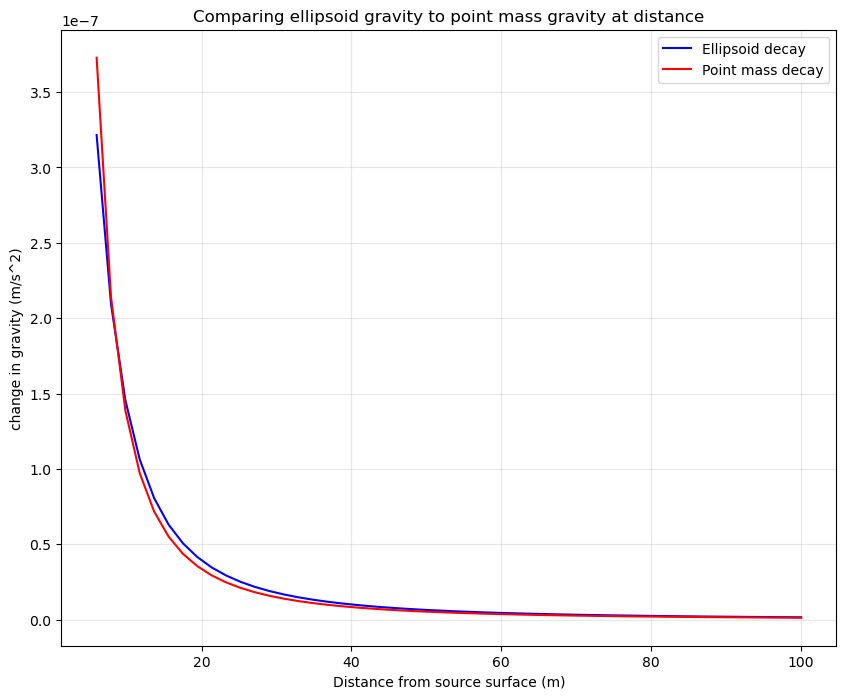

In [130]:
# plot 1 - comparing ellipsoid decay with distance to point source decay with distance

# set up an array of points - easiest along an axis
z = np.linspace(6, 100, 50)
x = y = np.zeros_like(z)

# lists to hold variables
mag = []
gz = []
point_gz = []

# iterate over z component and append the calculated values
for i in range(len(x)):
    _ , _ , gz_val = calculate_delta_gs_triaxial(x[i], y[i], z[i], 6, 4, 2)
    point_grav = pointgrav(x[i], y[i], z[i], 0, 0, 0, ellipsoid_mass)
    point_gz.append(point_grav)
    gz.append(gz_val)

# plot findings
plt.figure(figsize = (10, 8))
plt.title("Comparing ellipsoid gravity to point mass gravity at distance")
plt.plot(z, np.abs(gz), color = 'blue', label='Ellipsoid decay')
plt.plot(z, np.abs(point_gz), color = 'red', label='Point mass decay')
plt.legend()
plt.xlabel('Distance from source surface (m)')
plt.ylabel('change in gravity (m/s^2)')
plt.grid(alpha=0.3)

## work in progress

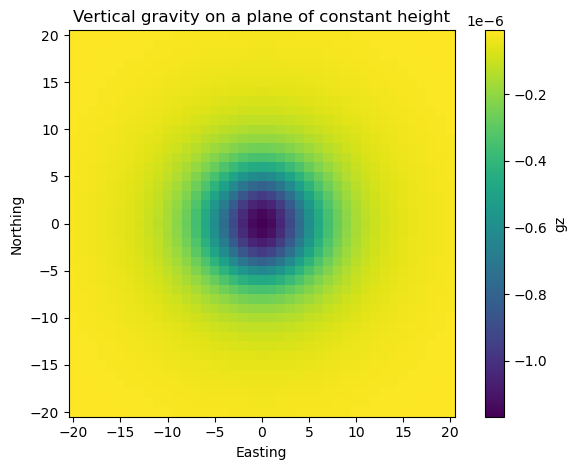

In [173]:
def calc_gz_array(func, spacing, region, height, a, b, c):
    
    """Function to call one of the gz functions,
    and use it for an array of coordinates.
    
    Parameters
    ----------
    
    # definitely these...
    function (func): the ellipsoid function to be used (triaxial, oblate, prolate)
    a, b, c (float): the semiaxes lengths of the ellipsoid
    
    # some form of...
    xs, ys, zs (array): sets of arrays denoting the coordinates of the observation point
    currently using the verde grid_coordinates function
    
    # in reality this should probably be a coordinate matrix of [[[ , , ] , [ , , ] , [ , , ]]] etc...
    
    
    Returns 
    -------
    z gravity component... in some format 
    
    """
    # would there be an easier way of doing this for 3D co ordinates??
    # otherwise would have to loop again over k
    
    # set the coord points

    easting, northing, elv = vd.grid_coordinates(region=region, spacing=spacing, extra_coords=5)
    gz_2d = np.empty_like(easting)

    # loop over the easting sizes (= northing = elv)
    # bit clunky??
    for i in range(easting.shape[0]):
        for j in range(easting.shape[1]):
            try:
                _, _, gz = calculate_delta_gs_triaxial(easting[i, j], northing[i, j], elv[i, j], a, b, c)
                gz_2d[i, j] = gz
            except ValueError: # give nan values when ValueError thrown in the ellips. function
                gz_2d[i, j] = np.nan 
                
    return easting, northing, gz_2d

# test and plot 
e, n, g = calc_gz_array(calculate_delta_gs_triaxial, 1, (-20, 20, -20, 20), 6, 6, 5, 4)

plt.pcolormesh(e, n, g)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz")
plt.title("Vertical gravity on a plane of constant height")
plt.xlabel("Easting")
plt.tight_layout()
plt.ylabel("Northing")
plt.show()




In [ ]:
# plot 1 - visualising how delta_g_z changes with distance from the ellipsoid 

def plot_colourmap_gz(x, y, z, a, b, c):
    """
    Creates northing and easting (x, y) coordinates (fixed area for now),
    Eliminates those within the ellipsoid body,
    Calculates gz for those outside the body,
    Plots 2D colourmap of the gz value with location.
    
    Parameters
    ----------
    a, b, c, x, y, z
    
    Returns
    -------
    None. Plots colourmap.
    """


Questions:

Is it ok to leave decay graph as is? Does it need to be in a function? Is there a more effeicient method?
Do tests need docstrings?
Passing values into the test?
What tests can be done for the ellipsoid functions? Maybe something to do with the scipy point mass approximation? But zero division errors!
Bit clunky for the colourmap creation and the creation of the gz values for the coordinates.